# Tutorial 16 - GRB FRED

Gamma-ray burst (GRB) light curves come in many forms and shapes. The most common shape is called FRED, or fast-rise, exponential decay. See an example below (not the one we'll be working with today). 

In today's tutorial we will 
- read in some light curve data of a very bright GRB 
- try to fit an exponential decay function to the post-peak lightcurve
- determine the decay timescale, $\tau$

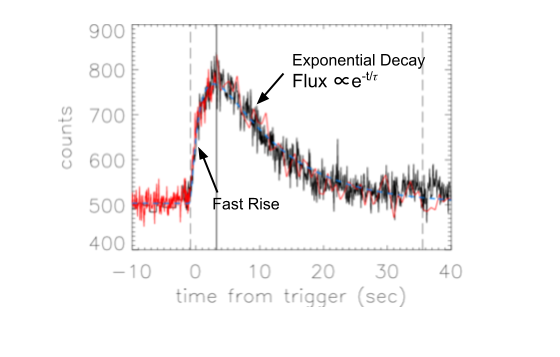

In [3]:
# Let's import some needed modules
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from scipy import stats

The next cell will read in a table from the data FITS file. We will use astropy's `Table` object to do this. 

The table contains the light curve data. 

In [4]:
# Run this cell

# The url to get the FITS file from
data_url = 'https://heasarc.gsfc.nasa.gov/FTP/fermi/data/gbm/triggers/2023/bn230812790/current/glg_ctime_n0_bn230812790_v00.pha'

# Reading in the table with the light curve data
# This is the 3rd HDU (index 2) in the file
rates_table = Table.read(data_url, hdu=2)

You can find the column names of an astropy table using the attribute `colnames`

Execute the cell below to print out the column names of `table_ebins`

In [5]:
print(rates_table.colnames)

['COUNTS', 'EXPOSURE', 'QUALITY', 'TIME', 'ENDTIME']


You can execute a cell with just the table in it to print out a formatted view of an astropy table

Execute the cell below to view a portion of table

In [6]:
rates_table

COUNTS,EXPOSURE,QUALITY,TIME,ENDTIME
ct,s,,s,s
uint16[8],float32,int16,float64,float64
18 .. 13,0.25518343,0,713558496.8377659,713558497.093766
16 .. 19,0.2551676,0,713558497.093766,713558497.3497659
27 .. 11,0.25520697,0,713558497.3497659,713558497.605766
17 .. 13,0.2552223,0,713558497.605766,713558497.861766
20 .. 11,0.25524306,0,713558497.861766,713558498.117784
13 .. 10,0.25525096,0,713558498.117784,713558498.373784
25 .. 12,0.25520945,0,713558498.373784,713558498.629784
16 .. 14,0.25531068,0,713558498.629784,713558498.8857839


Find and print the shape of the `COUNTS` column of `rates_table`

In [7]:
print(rates_table['COUNTS'].shape)

(14829, 8)


The light curve of a GRB can be different in different energy ranges, so we want to pick a narrower band than the full energy range. 

Let's sum the counts over the 2 energy bins that will give us the energy range 26.93867 keV to 101.62812 keV, into a single 1D array. (energy bin info stored in a differnt HDU)

Then let's make that a new column in the table

In [8]:

# Make 1D counts array here

counts_1D = rates_table['COUNTS'][:,2] + rates_table['COUNTS'][:,3]

In [9]:
# Now let's add it to the table as a new column
# The astropy Table object let's us do this easily, like below
# table_name['New_Column_Name'] = array to go in column
rates_table['COUNTS1D'] = counts_1D

You may have noticed that the values in the exposure column are not all the same. To make a light curve, we want to look at the count rate, and not the counts across different exposures

Let's make a new column in the table, named RATES, that gives us the count rate in our 26.93867 keV to 101.62812 keV energy range

In [10]:
# Calculate the rates and add to the table as a new column here

rate_counts = rates_table['COUNTS1D']/rates_table['EXPOSURE']
rates_table['RATES'] = rate_counts
#rates_table

C:\Users\Insan\AppData\Local\Temp\ipykernel_16396\1378522962.py:3: RuntimeWarning: invalid value encountered in divide
  rate_counts = rates_table['COUNTS1D']/rates_table['EXPOSURE']


The exponential decay portion of the light curve starts when the rising portion ends (at the time of maximum rates)

Let's find the time with the highest rate, and call it `t_max`

Hint: there may be some bad values in the table, so make sure to use the `nan` version of numpy commands

In [11]:
max_rate = np.nanmax(rates_table['RATES'])
print(max_rate)
max_index = np.where(rates_table['RATES'] == max_rate)[0][0]
t_max = rates_table['TIME'][max_index]
print(t_max)

40616.156
713559498.073596


The time column is in seconds since 2001, which is a large and difficult number to use.

Let's instead make another column that gives us the time relative to t_max. 

In [12]:
# execute this cell 
rates_table['dt'] = rates_table['TIME'] - t_max

Now let's plot our light curve, with rates on the y-axis and dt on the x-axis

Text(0, 0.5, 'Rate (counts/s)')

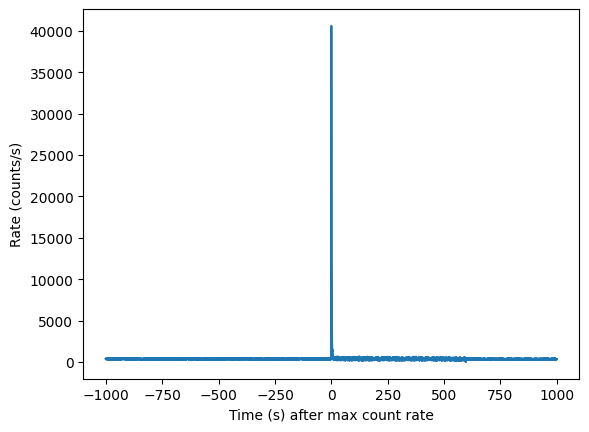

In [13]:
plt.plot(rates_table['dt'], rates_table['RATES'])
plt.xlabel('Time (s) after max count rate')
plt.ylabel('Rate (counts/s)')

You may notice that the GRB lasts a much smaller amount of time than the duration of the file

Let's use `plt.xlim()` to make that plot again but this time only showing dt from -30 to +30 seconds. 

Text(0, 0.5, 'Rate (counts/s)')

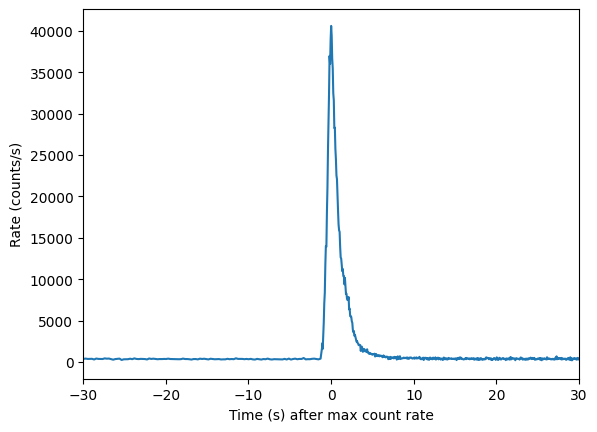

In [14]:
plt.xlim(-30,30)
plt.plot(rates_table['dt'], rates_table['RATES'])
plt.xlabel('Time (s) after max count rate')
plt.ylabel('Rate (counts/s)')

There's a lot of data that we don't really need, so let's use a boolean array to create a new table with only a subset of the data 

In [15]:
# boolean array that is True when the absolute value of dt is less than 30
# or each row where dt is inside +/- 30 s of t_max
bl_selection = (np.abs(rates_table['dt']) < 30)

# This will create a smaller table, rates_tab
# with only the rows at t_max +/- 30 s
rates_tab = rates_table[bl_selection]

In [16]:
# execute this cell to view the smaller table 
rates_tab

COUNTS,EXPOSURE,QUALITY,TIME,ENDTIME,COUNTS1D,RATES,dt
ct,s,,s,s,ct,ct,s
uint16[8],float32,int16,float64,float64,uint16,float32,float64
24 .. 13,0.2551625,0,713559468.1209921,713559468.376992,94,368.39267,-29.952603936195374
23 .. 15,0.2550976,0,713559468.376992,713559468.632992,103,403.76703,-29.696604013442993
32 .. 13,0.2551521,0,713559468.632992,713559468.888992,92,360.56924,-29.440603971481323
31 .. 15,0.2551332,0,713559468.888992,713559469.145012,94,368.43497,-29.184604048728943
25 .. 13,0.2551495,0,713559469.145012,713559469.401012,96,376.24997,-28.92858397960663
37 .. 14,0.2551938,0,713559469.401012,713559469.657012,75,293.8943,-28.672584056854248
28 .. 18,0.25512353,0,713559469.657012,713559469.913012,104,407.64566,-28.416584014892578
36 .. 13,0.25516173,0,713559469.913012,713559470.169032,93,364.4747,-28.160583972930908


In the last plot the rates before and after the GRB looked to be almost 0. They're not actually 0 though, just a lot smaller than the GRB count rate. 

Let's plot the light curve one more time, but this time let's make the y-axis logarithmic. A logarithmic scale makes it much easier to view a large range of values and see details in smaller values. 

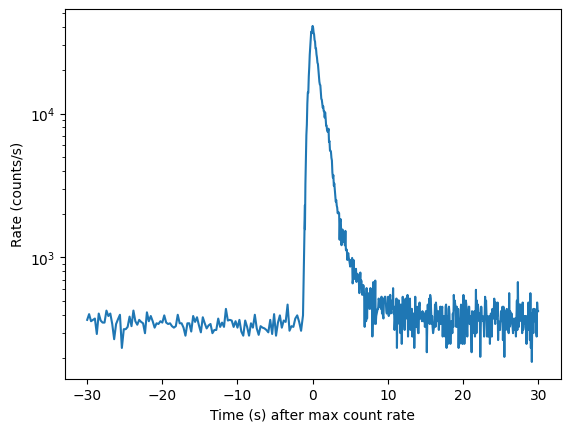

In [17]:
plt.plot(rates_tab['dt'], rates_tab['RATES'])
plt.xlabel('Time (s) after max count rate')
plt.ylabel('Rate (counts/s)')

# You can set the "scale" with plt.yscale or plt.xscale
plt.yscale('log')

Now you can see the pre-burst background was larger than 0, and looked to be pretty constant. Let's estimate the background rate during the GRB to be about the same as the rate just before the GRB. 

This is known as an off-on analysis, using the "off-time" to estimate the background during the "on-time". 

Use a boolean array to select the times where `dt` is greater -25 s and less than -5 s. Then find the average rate during that time. 

In [ ]:
bkg_bool_array = (rates_tab['dt'] < -5) & (rates_tab['dt'] > -25)

avg_bkg_rate = np.mean(rates_tab['RATES'][bkg_bool_array])

NameError: name 'rates_tab' is not defined

To find the signal strength, we need to find the rates above background (though our bkg rate is relatively small here). 

Let's make one more column for the bkg subtracted rates, called rates_bkg_sub

In [19]:
# execute this cell to do this
rates_tab['rates_bkg_sub'] = rates_tab['RATES'] - avg_bkg_rate

Now we have one more thing to calculate before we can fit the exponential decay function to our data. We need the counting error for each observation. 

Recall from last lecture and tutorial how to calculate the 1 sigma error on the count rates 

In [20]:


rates_tab['rates_sigma'] = np.sqrt(rates_tab['COUNTS1D']) / rates_tab['EXPOSURE']

In [21]:
def exp_decay(t, A, tau):
    '''
    Find the rate at time t, given an amplitude and decay time scale for the
    exponential decay phase of a GRB. 
    
    rate(t) = A*e^(-t / tau)
    
    
    INPUTS:
    t - time, float or array of floats
    A - the amplitude, or rate at t=0, float
    tau - the decay time scale, float
    
    RETURNS:
    rate - the rate at time, t or array of rates at times t
    '''
    
    # exponential decay formula
    rate = A*np.exp(-t/tau)
    return rate

In [22]:
# the amplitude will be the maximum signal rate

A = np.max(rates_tab['rates_bkg_sub'])


We only want to fit the light curve starting at the peak, so let's make a boolean array that selects `dt` from 0 - 4 s. 

Then let's first guess tau may be around 2 s, and make a plot of the LC from dt 0 - 4 s and the exponential decay curve at those times with tau = 2.5 s.

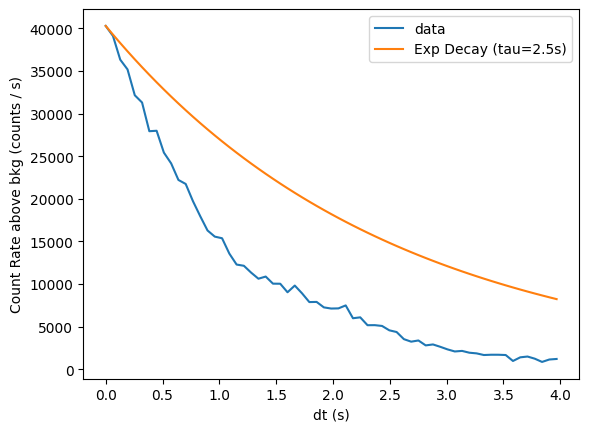

In [23]:
# boolean array to pick the data we're going to fit
bl_fit = (rates_tab['dt'] >= 0.0) & (rates_tab['dt'] < 4)

# The rates data we're going to fit
data_lc = rates_tab['rates_bkg_sub'][bl_fit]

# Let's first look at a guess of tau = 2.5 s
tau = 2.5 # seconds

# Get the exponentail decay as a function of time
exp_decay_lc = exp_decay(rates_tab['dt'][bl_fit], A, tau)

plt.plot(rates_tab['dt'][bl_fit], data_lc, label='data')

plt.plot(rates_tab['dt'][bl_fit], exp_decay_lc, label='Exp Decay (tau=2.5s)')

plt.xlabel('dt (s)')
plt.ylabel('Count Rate above bkg (counts / s)')
plt.legend()

This doesn't look quite right, but looks close at least. Looks like it should decay quicker, so let's try our brute force method to find the best tau and choose smaller values

Make a function to calculate the $\chi^2$ value of our exponential decay curve against our observed data

$\chi^2 = \Sigma_i (\frac{data_i - f(t_i)}{\sigma_i})^2$

where $f(t_i)$ is your exponential decay function

In [24]:
# Fill in the BLANK

def calc_chi2(data, func_vals, sigma):
    '''
    
    evaluates
    
    $\chi^2 = \Sigma_i (\frac{data_i - func(t_i)}{\sigma})^2$
    
    INPUTS:
    
    data - your observed data, array 
    
    func_vals - what the function you're fitting gives you at the same times of your data points, array
    
    sigma - the 1 sigma errors on your data, array
    
    RETURNS:
    
    chi2 - the chi2 value 
    
    '''
    
    chi2 = np.sum(((data - func_vals) / sigma)**2)
    
    return chi2

Now let's use our brute force method and calculate our chi2 values at a large amount of taus

Fill in the BLANKs below to calculate the chi2 values using your selected data from dt 0 s to 4 s

In [25]:
# let's use taus ranging from 0.25 s to 2.25 s
taus = np.linspace(0.25, 2.25, 200+1)

# initinalize an array for the chi2 values that's the same length as the number of taus
chi2s = np.zeros_like(taus)

for i in range(len(chi2s)):
    
    exp_decay_rates = exp_decay(rates_tab['dt'][bl_fit], A, taus[i])
    chi2s[i] = calc_chi2(data_lc, exp_decay_rates, rates_tab['rates_sigma'][bl_fit])


Print out the tau that mimimizes the chi2 value

In [26]:


best_fit_tau = taus[np.argmin(chi2s)]
print(best_fit_tau)

1.0899999999999999


Plot your taus on the x-axis and your chi2 values on the y-axis, does your answer align where you see the miminum? 

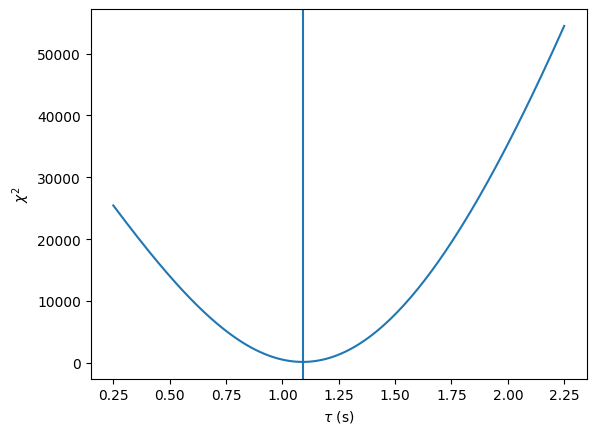

In [27]:
plt.plot(taus, chi2s)

plt.xlabel(r'$\tau$ (s)')
plt.ylabel(r'$\chi^2$')

# plot a vertical line at x=best_fit_tau
plt.axvline(best_fit_tau)

Now let's plot the data and the exponential decay curve that best describes the data!

Text(0, 0.5, 'Bkg subtracted count rate (counts / s)')

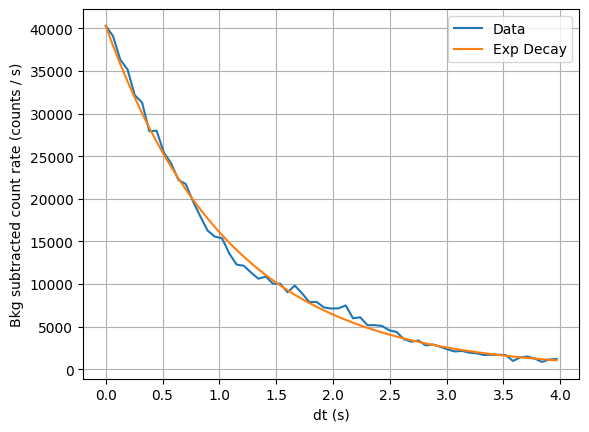

In [28]:
plt.plot(rates_tab['dt'][bl_fit], rates_tab['rates_bkg_sub'][bl_fit], label='Data')

plt.plot(rates_tab['dt'][bl_fit], exp_decay(rates_tab['dt'][bl_fit], A, best_fit_tau), label='Exp Decay')

plt.grid(True)
plt.legend()

plt.xlabel('dt (s)')
plt.ylabel('Bkg subtracted count rate (counts / s)')

Find the normalized residuals of the fit. 

$\text{norm_resid}_i = \frac{(data_i - f(t_i))}{\sigma_i}$

- Then plot plot them in a density histogram.

- On the same figure, plot a standard normal function ($\mu$=0, $\sigma$=1)

- Do the normalized residuals seem to be distributed like a standard normal?

-3.7282722686472525 4.7543997249130205


Text(0, 0.5, 'PDF')

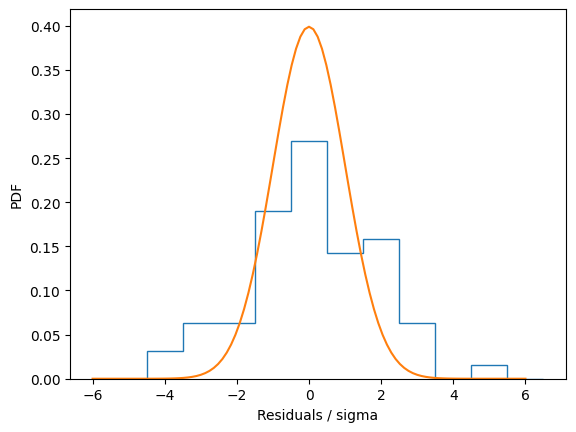

In [29]:
norm_resid = (rates_tab['rates_bkg_sub'][bl_fit] - exp_decay(rates_tab['dt'][bl_fit], A, best_fit_tau)) / rates_tab['rates_sigma'][bl_fit]

print(np.min(norm_resid), np.max(norm_resid))

# histogram bins that are centered on 0
bins = np.linspace(-6, 6, 1*12+1) + 0.5

plt.hist(norm_resid, bins=bins, histtype='step', density=True, label='data')

# make an x-axis that's more finely sampled than the hist bins
xax = np.linspace(-6, 6, 100+1)

# use scipy.stats's normal pdf to calculate the normal function
plt.plot(xax, stats.norm.pdf(xax), label='Norm PDF')

plt.xlabel('Residuals / sigma')

plt.ylabel('PDF')

Things in real data won't always be perfect. 

In this exercise we didn't calculate the error on our estimation of $\tau$. This was a very bright GRB and random counting errors are very small. The random error on $\tau$ would also be very small. Next time we'll do another exercise where statistical errors will dominate